# Time Series Forecasting
### Kasus Inflasi Indonesia

### Load data ke Pandas DataFrame

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import timedelta

# Import the data
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

df = pd.read_csv('data/Inflasi_TimeSeries.csv', header=None, skiprows=1, parse_dates=[0], date_parser=dateparse, names=['period', 'value'])

# Clean/Organize the data. 
print(df.head())
sns.set(style="ticks")

      period   value
0 2003-01-01  0.0868
1 2003-02-01  0.0760
2 2003-03-01  0.0717
3 2003-04-01  0.0762
4 2003-05-01  0.0715


### Preprocess

In [2]:
max_date = df.period.max()
min_date = df.period.min()

num_of_actual_points = df.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Range waktu: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
#print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))
print(df.head())

Range waktu: 01.01.2003 - 01.04.2019
      period   value
0 2003-01-01  0.0868
1 2003-02-01  0.0760
2 2003-03-01  0.0717
3 2003-04-01  0.0762
4 2003-05-01  0.0715


### Visualisasi data

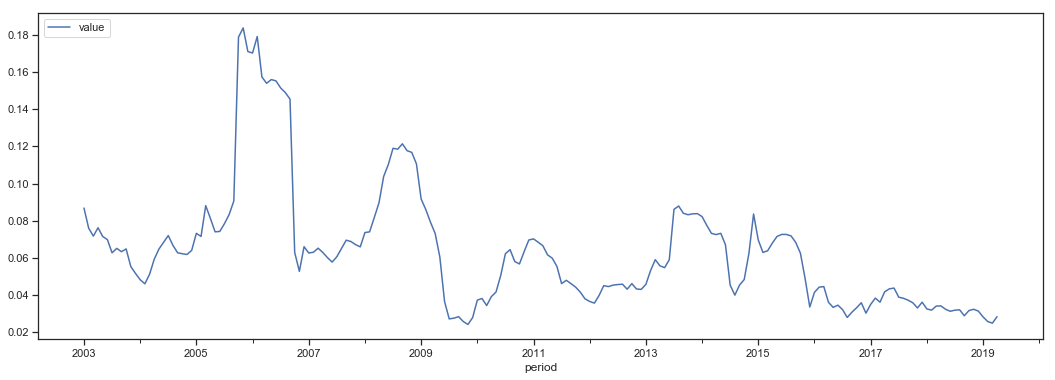

In [3]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax)
plt.legend(loc='upper left')
plt.show();

Sekarang kita menghitung koefisien untuk "memotong" garis. Metthod NumPy polyfit bisa melakukannya.
Kemudian kita tentukan fungsi polinomial menggunakan koefisien itu. Kita dapat melakukan ini pada satu dimensi menggunakan method poly1d NumPy.

In [4]:
line_coef = np.polyfit(df.index,df['value'],1)
print(line_coef)

polynomial = np.poly1d(line_coef)
# The intercept is ~86.59, the slops is ~0.11
print(polynomial(0))
print(polynomial(1))

[-0.0002989   0.09292003]
0.09292003004247383
0.09262112758887232


### Plot trendline pada data

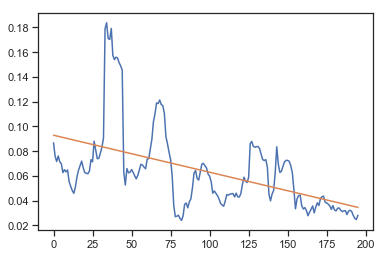

In [5]:
# Plot time series
plt.plot(df.index, df['value'])
# Plot least squares minimizing line
plt.plot(df.index, polynomial(df.index));

### Trend turun, per tahun seasonal

## Trend and seasonality

Dari visualisasi sudah cukup jelas bahwa inflasi memiliki fluktuasi berkala setiap tahun dan kecenderungan keseluruhan untuk turun.

Dengan demikian, kita dapat menyimpulkan bahwa time series memiliki komponen **trend** dan **seasonality** tahunan, dan kita dapat mencoba menguraikannya menggunakan paket **statsmodels**.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    freq=decompfreq,
    model=model)

In [7]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

### Tren/Trend

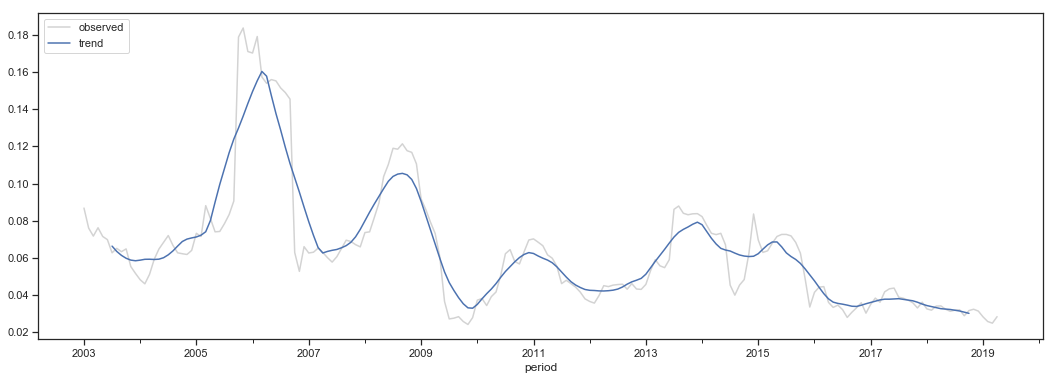

In [8]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend")
plt.legend(loc='upper left')

plt.show();

### Seasonality

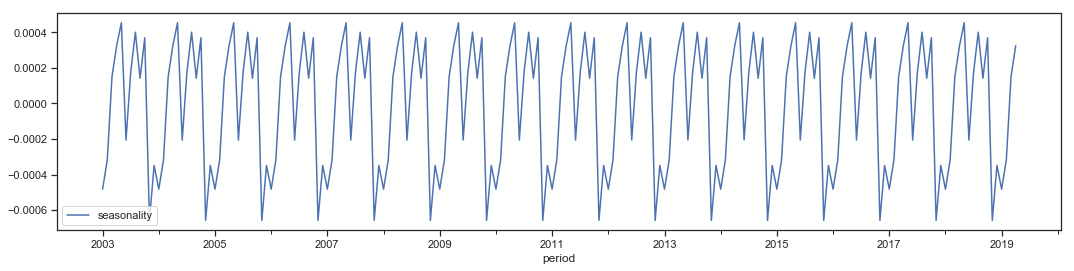

In [9]:
fig, ax = plt.subplots(figsize=(18,4))
seasonal.plot(ax=ax, label="seasonality")
plt.legend(loc='lower left')

plt.show();

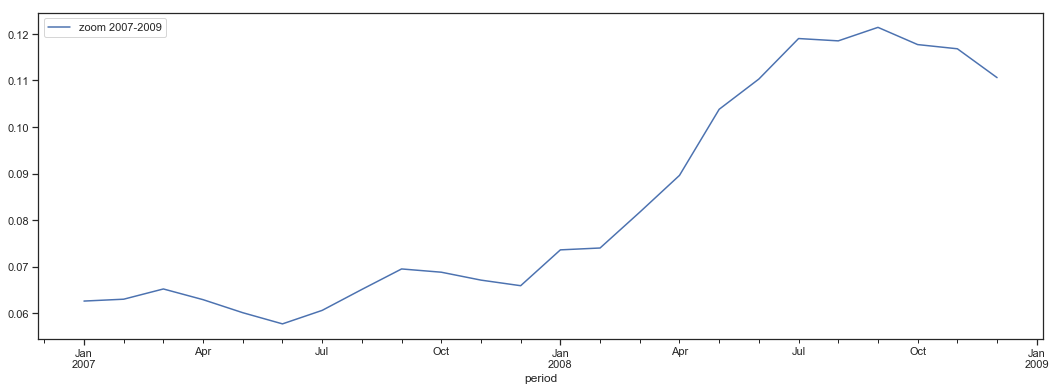

In [10]:
zoom_range = df[(df.period >= '2007-01-01') & (df.period < '2009-01-01')].index

fig, ax = plt.subplots(figsize=(18,6))
df.loc[zoom_range].plot(x="period", y="value", ax=ax, label="zoom 2007-2009")
plt.legend(loc='upper left')

plt.show();

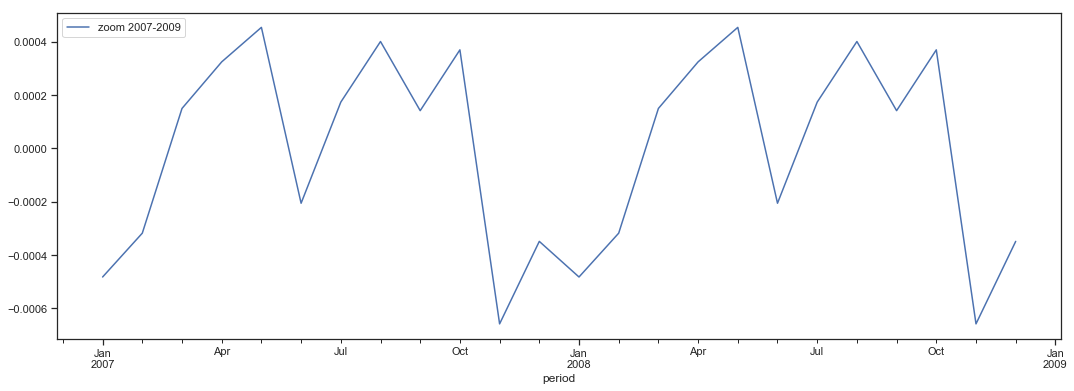

In [11]:
fig, ax = plt.subplots(figsize=(18,6))
seasonal[zoom_range].plot(x="period", y="value", ax=ax, label="zoom 2007-2009")
plt.legend(loc='upper left')

plt.show();

### Residu/Residual

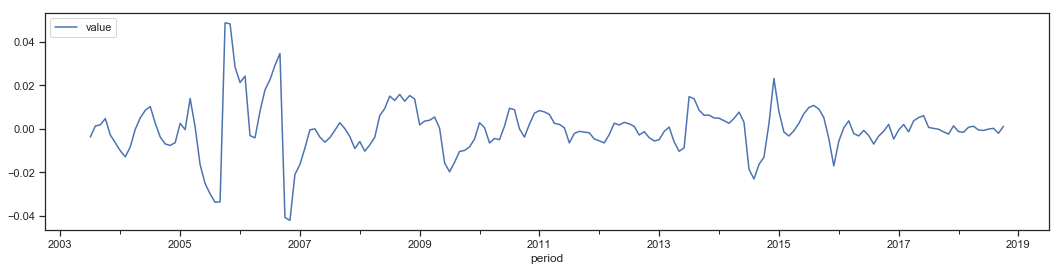

In [12]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality")
plt.legend(loc='upper left')

plt.show();

In [13]:
np.random.seed(seed=42)

train_range = df[df.period < '2015-01-01'].index
validate_range = df[(df.period >= '2015-01-01') & (df.period < '2017-01-01')].index
test_range = df[(df.period >= '2017-01-01') & (df.period < '2019-01-01')].index

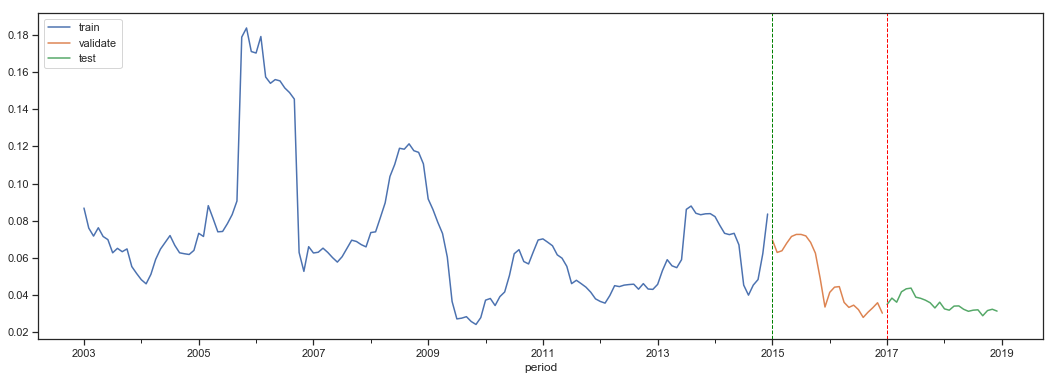

In [14]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[validate_range].plot(x="period", y="value", ax=ax, label="validate")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
plt.legend(loc='upper left')

plt.show();

### Prepare data for ANN model

While working with artificial network, it's always a good idea to properly scale your data.

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.value.astype(float).values.reshape(-1, 1));

### Convert observations into the seasonal learning data

Instead of directly leaning the number of visitors by the observation date, we will learn values in the next season based on the values in the previous one.

#### Thus, for new learning data we take vectors $x = [t - seasons, t)$, while the expected values are vectors $y = [t, t+ seasons)$.

In [16]:
def build_seasonal_learning_sequences(data, indices, seasons=12):
    train, validate, test = indices
    
    X_train = np.empty(shape=(0, seasons))
    y_train = np.empty(shape=(0, seasons))
    
    X_val = np.empty(shape=(0, seasons))
    y_val = np.empty(shape=(0, seasons))
    
    X_test = np.empty(shape=(0, seasons))
    y_test = np.empty(shape=(0, seasons))
    
    for i in range(seasons, data.shape[0] - seasons):
        X = data[i - seasons:i].reshape(1,-1)
        y = data[i:i + seasons].reshape(1,-1)
        if i in train:
            X_train = np.concatenate((X_train, X), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)
        elif i in validate:
            X_val = np.concatenate((X_val, X), axis=0)
            y_val = np.concatenate((y_val, y), axis=0)
        elif i in test:
            X_test = np.concatenate((X_test, X), axis=0)
            y_test = np.concatenate((y_test, y), axis=0)

    return X_train, y_train, X_val, y_val, X_test, y_test

#### For our data we observe the yearly seasonality, thus we select $seasons=12$

In [17]:
seasons = 12
indices = [train_range, validate_range, test_range]

X_train, y_train, X_val, y_val, X_test, y_test = build_seasonal_learning_sequences(
    data, indices, seasons)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [19]:
from GA_Inflasi import GA
#from Forecast_Inflasi import forecast
import time

Using TensorFlow backend.


In [ ]:
timeSeries = [seasons,X_train,y_train,X_val,y_val,X_test,y_test,scaler] 
start_time = time.time()

GA(timeSeries)

elapsed_time = time.time() - start_time


Instructions for updating:
Colocations handled automatically by placer.
Start model building
Instructions for updating:
Use tf.cast instead.
Finish model building
Start predict
Finish predict
Start model building
Finish model building
Start predict
Finish predict
Start model building
Finish model building
Start predict
Finish predict
Start model building
Finish model building
Start predict
Finish predict
Start model building
Finish model building
Start predict
Finish predict
Start model building
Finish model building
Start predict
Finish predict
Start model building
Finish model building
Start predict
Finish predict
Start model building


In [ ]:
from random import randint
randint(1,2)

## ANN model with keras

#### keras already supports the evaluation of metrics during the training, and already have MAE / MSE built-in support. We can create additionally $R^2$ and $Theil's U$ metrics.

In [ ]:
from keras import backend as K

In [ ]:
def r2_metric(y_true, y_pred):
    """Calculate R^2 statistics using observed and predicted tensors."""
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted tensors."""
    SS_res =  K.mean(K.square(y_true - y_pred))
    SS_true = K.mean(K.square(y_true))
    SS_pred = K.mean(K.square(y_pred))
    
    return K.sqrt(SS_res / (SS_true * SS_pred))

#### The main problem while working with ANNs is the choice of the network's parameters, such as number of layers and number of  neurons.

#### Hopefully, the researches in this field (see C. Hamzacebi) already came up with some recommendations:

* only 1 hidden layer
* number of input and output neurons can be taken as number of observations in a season
* number of hidden nodes should be detemined experimentally (but usually, a few is enough)

In [ ]:
from keras.layers import InputLayer, Dense, LSTM
from keras.models import Sequential
from keras.optimizers import SGD

sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=False)

model = Sequential()
model.add(InputLayer(input_shape=(1, seasons), name="input"))
model.add(LSTM(4, name="hidden", activation='sigmoid', use_bias = True, bias_initializer='ones'))
model.add(Dense(seasons, name="output", activation='linear', use_bias = True, bias_initializer='ones'))
model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=["mae", "mse", r2_metric, theils_u_metric])

#### Fit the model

In [ ]:
num_of_epochs = 100
history = model.fit(
    X_train, y_train,
    epochs=num_of_epochs,
    batch_size=1,
    verbose=0,
    validation_data=(X_val, y_val));
print(history.history.keys())

In [ ]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(history.history["mean_squared_error"], label="train MSE")
plt.plot(history.history["val_mean_squared_error"], label="validation MSE")
plt.legend(loc='upper left')
plt.show();

### Evaluate the model

In [ ]:
_, mae, mse, r2, u = model.evaluate(X_train, y_train, batch_size=1, verbose=0)

print("MAE (train): {:0.3f}".format(mae))
print("MSE (train): {:0.3f}".format(mse))
print("R2  (train): {:0.3f}".format(r2))
print("U   (train): {:0.3f}".format(u))

In [ ]:
_, mae, mse, r2, u = model.evaluate(X_val, y_val, batch_size=1, verbose=0)

print("MAE (val): {:0.3f}".format(mae))
print("MSE (val): {:0.3f}".format(mse))
print("R2  (val): {:0.3f}".format(r2))
print("U   (val): {:0.3f}".format(u))

### Forecast

In [ ]:
yhat_train = model.predict(X_train[::seasons])
yhat_val = model.predict(X_val[::seasons])
yhat_test = model.predict(X_test[::seasons])

yhat_train_unscaled = scaler.inverse_transform(yhat_train).flatten()
yhat_val_unscaled = scaler.inverse_transform(yhat_val).flatten()
yhat_test_unscaled = scaler.inverse_transform(yhat_test).flatten()

In [ ]:
y_train_unscaled = scaler.inverse_transform(y_train[::seasons]).flatten()
y_val_unscaled = scaler.inverse_transform(y_val[::seasons]).flatten()
y_test_unscaled = scaler.inverse_transform(y_test[::seasons]).flatten()

### Evaluate the forecast

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

mae = mean_absolute_error(y_test_unscaled, yhat_test_unscaled)
mse = mean_squared_error(y_test_unscaled, yhat_test_unscaled)
r2 = r2_score(y_test_unscaled, yhat_test_unscaled)
u = theils_u_metric(y_test_unscaled, yhat_test_unscaled)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[train_range].period.values)[seasons:], yhat_train_unscaled,
        color="red", label="train")
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="green", label="val")
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the overall period')

plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="blue", label="predicted")

df.loc[validate_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the val range')

plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

plt.show();

In [ ]:
from GA_Inflasi import main
from Forecast_Inflasi import forecast